<a href="https://colab.research.google.com/github/Cycyplay/M2_DeepLearning_Classification/blob/main/Deep_Learning_Projet_Classification_Version_R%C3%A9seau_Existant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet M2 Deep Learning Classification 
## Version Réseau Préentrainé


J'ai décidé d'utiliser un réseau convnet entrainé sur la base d'image ImageNet,
base qui represente de nombreuses catégories, d'objets du quotidien aux animaux etc.

**L'idée : classer les différents courants artistiques par la présence de différents objets dans les oeuvres**

À faire expliquer pourquoi j'ai utilisé VGG16 plutot que les autres avec le tableau voir doc KERAS


# Test d'un réseau existant ImageNet pour la classification d'objet présent sur les oeuvres

In [2]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline 

from google.colab import drive
drive.mount('/content/drive')


x_test = np.load('./drive/MyDrive/DeepLearning_Dataset/x_test.npy')
x_train = np.load('./drive/MyDrive/DeepLearning_Dataset/x_train.npy')
y_test = np.load('./drive/MyDrive/DeepLearning_Dataset/y_test.npy')
y_train = np.load('./drive/MyDrive/DeepLearning_Dataset/y_train.npy')

Mounted at /content/drive


In [3]:
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense

In [4]:
image = cv2.resize(x_test[1000], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

model = VGG16(weights="imagenet")
preds = model.predict(image)

1/1 [==============================] - 1s 841ms/step


35363/35363 [==============================] - 0s 0us/step
1. breastplate: 4.65%
2. Sussex_spaniel: 3.69%
3. Welsh_springer_spaniel: 3.52%
4. cuirass: 3.15%
5. English_foxhound: 2.72%


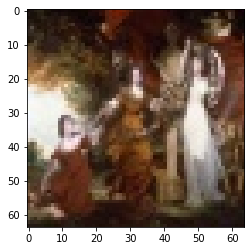

In [5]:
P = decode_predictions(preds)
for (i, (imagenetID, label, prob)) in enumerate(P[0]):
	print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))
 
plt.imshow(x_test[1000], interpolation='nearest')
plt.show()

# Fine Tuning

In [18]:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(64,64,3))

# add a global spatial average pooling layer
x = base_model.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = keras.layers.Flatten()(x)
x = Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 9 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
print(x_test.shape)
print(y_test.shape)
model.fit(x_train, y_train, verbose=1, batch_size=128, epochs=10, validation_data=(x_test, y_test))

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
# from keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# model.fit(...)

(1701, 64, 64, 3)
(1701,)
Epoch 1/10
54/54 [==============================] - 309s 6s/step - loss: 5.3485 - accuracy: 0.3237 - val_loss: 2.0840 - val_accuracy: 0.3433
Epoch 2/10
54/54 [==============================] - 304s 6s/step - loss: 1.5596 - accuracy: 0.4664 - val_loss: 1.9175 - val_accuracy: 0.3939
Epoch 3/10
54/54 [==============================] - 304s 6s/step - loss: 1.1432 - accuracy: 0.5947 - val_loss: 1.9537 - val_accuracy: 0.4074
Epoch 4/10
54/54 [==============================] - 305s 6s/step - loss: 0.8843 - accuracy: 0.6804 - val_loss: 1.9806 - val_accuracy: 0.4303
Epoch 5/10
54/54 [==============================] - 303s 6s/step - loss: 0.6819 - accuracy: 0.7580 - val_loss: 2.0444 - val_accuracy: 0.4368
Epoch 6/10
54/54 [==============================] - 279s 5s/step - loss: 0.5310 - accuracy: 0.8175 - val_loss: 2.1652 - val_accuracy: 0.4409
Epoch 7/10
54/54 [==============================] - 303s 6s/step - loss: 0.4043 - accuracy: 0.8675 - val_loss: 2.2899 - val_accu